In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE


In [75]:
# Function to load and process images from a specified folder
def load_images(folder_path, image_size):
    images = []
    for filename in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            # Convert to grayscale and resize
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (image_size, image_size))
            images.append(resized_image.flatten())  # Flatten to 1D array for modeling
    return images


In [76]:
# Function to prepare training and testing datasets
def preprocess_data(data_path, image_size):
    training_data = {}
    testing_data = {}
    # Load images for each tumor type
    for tumor_type in ['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'no_tumor']:
        training_images = load_images(os.path.join(data_path, 'Training', tumor_type), image_size)
        testing_images = load_images(os.path.join(data_path, 'Testing', tumor_type), image_size)
        training_data[tumor_type] = training_images
        testing_data[tumor_type] = testing_images
    return training_data, testing_data

# Define the data path and image size
data_path = '/content/drive/MyDrive/dataset'  # Adjust to your data path
image_size = 128  # Example image size (128 x 128 pixels)

# Preprocess the data
training_data, testing_data = preprocess_data(data_path, image_size)


In [77]:
# Function to extract features using Histogram of Oriented Gradients (HOG)
def extract_features(image, image_size):
    reshaped_image = np.reshape(image, (image_size, image_size))
    # Example using Histogram of Oriented Gradients
    features = hog(
        reshaped_image,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False
    )
    return features

# Apply feature extraction and PCA to the training data
training_features = []
training_labels = []
for tumor_type, images in training_data.items():
    features = [extract_features(image, image_size) for image in images]
    training_features.extend(features)
    training_labels.extend([tumor_type] * len(features))

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust as needed
training_features_reduced = pca.fit_transform(training_features)


In [78]:
# Create an image data generator for basic data augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,  # Small rotation to avoid excessive distortion
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Small zoom
    horizontal_flip=True  # Flip the image horizontally
)

# Apply data augmentation to the training dataset
augmented_training_images = []
augmented_training_labels = []

for tumor_type, images in training_data.items():
    for image in images:
        # Ensure the image has the correct 4D shape (batch_size, height, width, channels)
        reshaped_image = np.reshape(image, (image_size, image_size, 1))  # Add channel dimension
        reshaped_image = np.expand_dims(reshaped_image, axis=0)  # Add batch dimension

        # Generate augmented images (example: 3 augmentations to avoid long runtime)
        flow = data_gen.flow(
            reshaped_image,
            batch_size=1,
            seed=42  # Ensure consistent results across runs
        )

        augmented_images = [next(flow)[0].flatten() for _ in range(5)]  # 3 augmentations per image
        augmented_training_images.extend(augmented_images)
        augmented_training_labels.extend([tumor_type] * len(augmented_images))  # Corresponding labels

In [79]:
# Apply SMOTE for class balancing
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(training_features_reduced, training_labels)


In [80]:
# Train a classifier with hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'rbf'],  # Different kernels to experiment with
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': ['scale', 'auto']  # For non-linear kernels like RBF
}

# Apply GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring='accuracy',
    cv=5  # Cross-validation
)

grid_search.fit(X_resampled, y_resampled)  # Fit the classifier with resampled data
classifier = grid_search.best_estimator_  # Get the best classifier from the grid search

print("Best parameters:", grid_search.best_params_)  # Display the best hyperparameters


Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Test Accuracy: 76.39593908629442 %


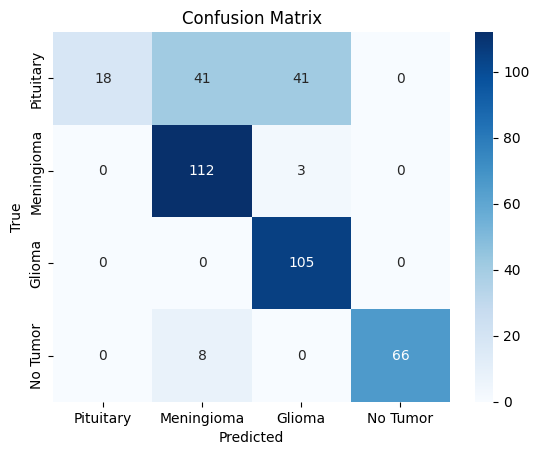

Classification Report:
              precision    recall  f1-score   support

   Pituitary       1.00      0.18      0.31       100
  Meningioma       0.70      0.97      0.81       115
      Glioma       0.70      1.00      0.83       105
    No Tumor       1.00      0.89      0.94        74

    accuracy                           0.76       394
   macro avg       0.85      0.76      0.72       394
weighted avg       0.83      0.76      0.71       394



In [81]:
# Apply feature extraction and PCA to the testing data
testing_features = []
testing_labels = []

for tumor_type, images in testing_data.items():
    features = [extract_features(image, image_size) for image in images]
    reduced_features = pca.transform(features)  # Apply the same PCA transformation
    testing_features.extend(reduced_features)
    testing_labels.extend([tumor_type] * len(reduced_features))

# Predict using the trained classifier
predictions = classifier.predict(testing_features)

# Calculate accuracy
accuracy = accuracy_score(testing_labels, predictions)
print("Test Accuracy:", accuracy*100,'%')

# Generate a confusion matrix
conf_matrix = confusion_matrix(testing_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor'], yticklabels=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a detailed classification report
classification_report_str = classification_report(testing_labels, predictions, target_names=['Pituitary', 'Meningioma', 'Glioma', 'No Tumor'])
print("Classification Report:")
print(classification_report_str)
